## IMPORTS

In [ ]:
!pip install tensorflow
import pandas as pd
import numpy as np
from pathlib import Path
import os.path
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:
from google.colab import files

# Upload the dataset zip file
uploaded = files.upload()


Saving Fish Dataset.zip to Fish Dataset.zip


In [ ]:
import zipfile
import os

# Your uploaded ZIP file name
zip_file = '/content/Fish Dataset.zip'  # Ensure correct path

# Extract contents
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('/content/Fish_Dataset')  # Extract to a folder

# Now list the extracted contents
extracted_path = '/content/Fish_Dataset'
print("Extracted folders:", os.listdir(extracted_path))


Extracted folders: ['Fish Dataset']


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for MobileNetV2
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ✅ Correct path to the data folder
data_dir = '/content/Fish Dataset/images.cv_jzk6llhf18tm3k0kyttxz/data'

# Load datasets
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Print classes
class_names = train_dataset.classes
print(f"Classes: {class_names}")


Classes: ['animal_fish', 'animal_fish_bass', 'black_sea_sprat', 'gilt_head_bream', 'hourse_mackerel', 'red_mullet', 'red_sea_bream', 'sea_bass', 'shrimp', 'striped_red_mullet', 'trout']


In [ ]:
# Check a batch of images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Print the shape of the batch
print(f"Image batch shape: {images.shape}")
print(f"Label batch shape: {labels.shape}")

# Print the labels and corresponding fish classes
print("Labels:", labels)
print("Class names:", class_names)


Image batch shape: torch.Size([32, 3, 224, 224])
Label batch shape: torch.Size([32])
Labels: tensor([ 6, 10,  4,  0,  9,  4,  9,  7,  4, 10,  0,  9,  0,  9,  4,  7,  0,  5,
         4,  4,  0,  0,  7,  3,  0,  4,  7,  7, 10,  3,  9,  8])
Class names: ['animal_fish', 'animal_fish_bass', 'black_sea_sprat', 'gilt_head_bream', 'hourse_mackerel', 'red_mullet', 'red_sea_bream', 'sea_bass', 'shrimp', 'striped_red_mullet', 'trout']


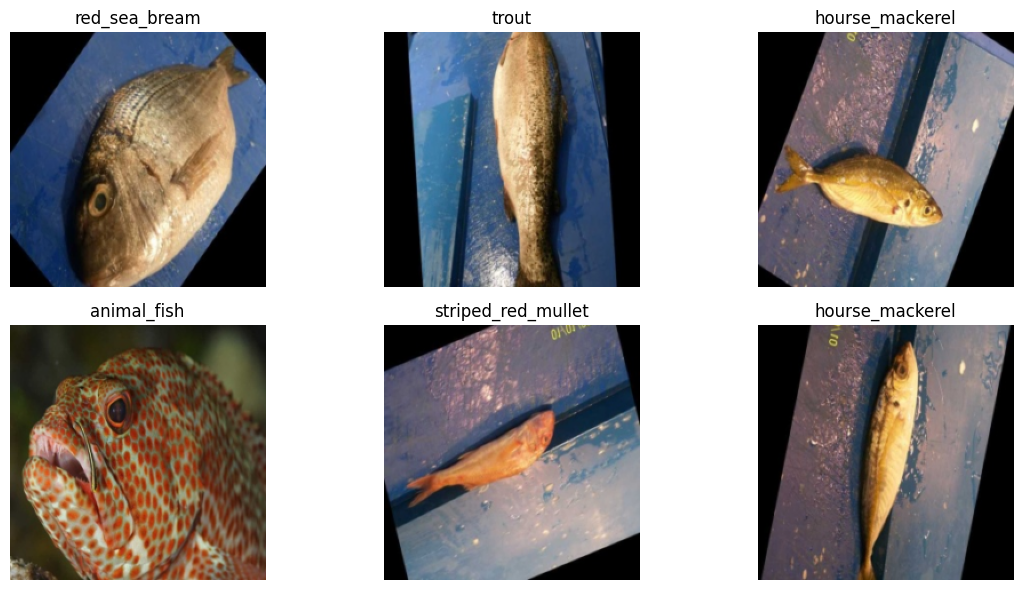

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Unnormalize and convert tensor image to numpy
def imshow(img, title):
    img = img.numpy().transpose((1, 2, 0))  # CxHxW -> HxWxC
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# Show 6 images from the batch
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    imshow(images[i], title=class_names[labels[i]])
plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-trained MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)

# Freeze all parameters
for param in model.parameters():
    param.requires_grad = False

# Replace classifier to match the number of classes
num_classes = len(class_names)
model.classifier[1] = nn.Linear(model.last_channel, num_classes)

# Move model to device
model = model.to(device)
print(model)


Using device: cpu


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 52.2MB/s]


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
import torch.optim as optim

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (only the classifier params will be updated)
optimizer = optim.Adam(model.classifier[1].parameters(), lr=0.001)


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 20)

        # Training phase
        model.train()
        train_loss, train_correct = 0.0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == labels.data)

        epoch_train_loss = train_loss / len(train_loader.dataset)
        epoch_train_acc = train_correct.double() / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels.data)

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = val_correct.double() / len(val_loader.dataset)

        print(f"Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f}")
        print(f"Val   Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")

    return model


In [ ]:
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10)



Epoch 1/10
--------------------
Train Loss: 0.5832 Acc: 0.8798
Val   Loss: 0.1588 Acc: 0.9826

Epoch 2/10
--------------------
Train Loss: 0.1431 Acc: 0.9796
Val   Loss: 0.0732 Acc: 0.9954

Epoch 3/10
--------------------
Train Loss: 0.0895 Acc: 0.9867
Val   Loss: 0.0503 Acc: 0.9963

Epoch 4/10
--------------------
Train Loss: 0.0661 Acc: 0.9899
Val   Loss: 0.0367 Acc: 0.9973

Epoch 5/10
--------------------
Train Loss: 0.0536 Acc: 0.9900
Val   Loss: 0.0318 Acc: 0.9945

Epoch 6/10
--------------------
Train Loss: 0.0474 Acc: 0.9924
Val   Loss: 0.0247 Acc: 0.9963

Epoch 7/10
--------------------
Train Loss: 0.0361 Acc: 0.9929
Val   Loss: 0.0248 Acc: 0.9963

Epoch 8/10
--------------------
Train Loss: 0.0367 Acc: 0.9939
Val   Loss: 0.0201 Acc: 0.9963

Epoch 9/10
--------------------
Train Loss: 0.0314 Acc: 0.9952
Val   Loss: 0.0154 Acc: 0.9982

Epoch 10/10
--------------------
Train Loss: 0.0257 Acc: 0.9960
Val   Loss: 0.0183 Acc: 0.9945


In [ ]:
# After training loop
torch.save(model.state_dict(), "mobilenetv2_fish_classifier.pth")


In [ ]:
# Create model architecture
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = torch.nn.Linear(model.last_channel, len(class_names))
model.load_state_dict(torch.load("mobilenetv2_fish_classifier.pth", map_location=device))
model = model.to(device)
model.eval()
print("Model loaded and ready for inference.")


Model loaded and ready for inference.


In [ ]:
from PIL import Image

def predict_image(image_path, model, transform, class_names):
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        probs = torch.nn.functional.softmax(outputs, dim=1)

    predicted_class = class_names[predicted.item()]
    confidence = probs[0][predicted.item()].item()

    return predicted_class, confidence


In [ ]:
img_path = '/content/Fish Dataset/images.cv_jzk6llhf18tm3k0kyttxz/data/test/animal_fish_bass/00CQHPZMXGCH.jpg'  # Example

pred_class, confidence = predict_image(img_path, model, transform, class_names)
print(f"Predicted Class: {pred_class} | Confidence: {confidence:.2f}")


Predicted Class: animal_fish_bass | Confidence: 0.18


## Creating Data Frame

In [ ]:
all_files = list(image_dir.rglob("*"))
print(f"Total files found: {len(all_files)}")
print(all_files[:10])  # First 10 entries


Total files found: 0
[]
